## Read datasets

In [34]:
import pandas as pd
import numpy as np
import os

In [35]:
BTC = pd.read_parquet("BTC-USDT.parquet")
ETH = pd.read_parquet("ETH-USDT.parquet")
BNB = pd.read_parquet("BNB-USDT.parquet")

In [36]:
def _fill_data_dict(dir=os.listdir(), extension=".parquet", func=pd.read_parquet, splitter="-"):
    file_list = [file for file in dir if file.endswith(extension)]
    data_dict = {}
    for file in file_list:
        data_dict[file.split(splitter)[0]] = func(file)
    return data_dict

In [37]:
data_dict = _fill_data_dict()

In [38]:
data_dict

{'BNB':                            open        high         low       close  \
 open_time                                                             
 2017-11-06 03:54:00    1.500000    1.500000    1.500000    1.500000   
 2017-11-06 03:55:00    1.300000    1.300000    1.300000    1.300000   
 2017-11-06 03:56:00    1.300000    1.300000    0.500000    0.500000   
 2017-11-06 03:57:00    0.500000    0.610000    0.500000    0.610000   
 2017-11-06 03:58:00    1.100000    1.100000    1.100000    1.100000   
 ...                         ...         ...         ...         ...   
 2021-02-11 23:36:00  124.051697  124.099403  123.923698  123.974602   
 2021-02-11 23:37:00  123.985298  124.003799  123.813004  123.820396   
 2021-02-11 23:38:00  123.841499  123.952698  123.641502  123.700897   
 2021-02-11 23:39:00  123.770897  123.931396  123.337097  123.884598   
 2021-02-11 23:40:00  123.884598  123.951103  123.635597  123.754402   
 
                           volume  quote_asset_volume  

## Plotting

In [39]:
import matplotlib.pyplot as plt
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30, figsize=(15, 5)):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)
    plt.title(ts.name)
    plt.plot(ts[window:], label='ts', color="black")
    if plot_ma:
        plt.plot(rolling_mean, 'g', label='MA' + str(window), color="red")
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
        plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound, color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

WARNING - (py.warnings._showwarnmsg) - <ipython-input-39-169bf430f585>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA' + str(window), color="red")

  plt.plot(rolling_mean, 'g', label='MA' + str(window), color="red")



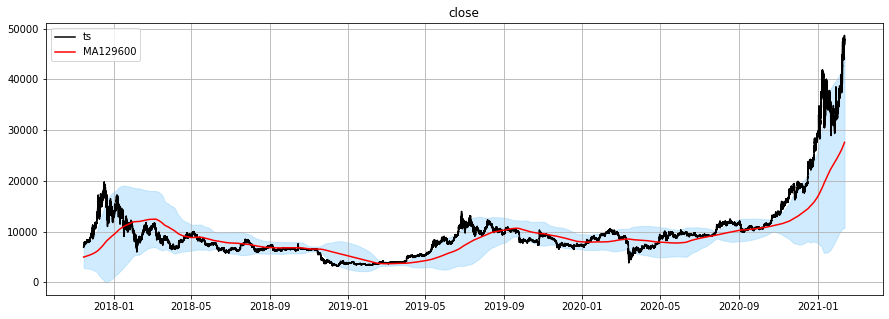

In [40]:
plot_ts(BTC['close'], plot_ma=True, plot_intervals=True, window=60*24*90, figsize=(15,5))

WARNING - (py.warnings._showwarnmsg) - <ipython-input-39-169bf430f585>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA' + str(window), color="red")

  plt.plot(rolling_mean, 'g', label='MA' + str(window), color="red")



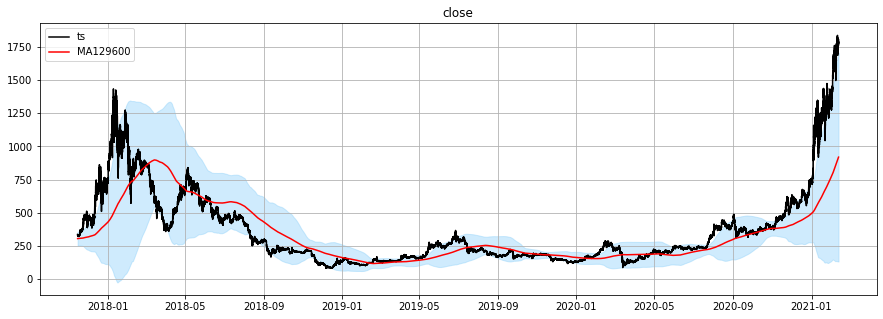

In [41]:
plot_ts(ETH['close'], plot_ma=True, plot_intervals=True, window=60*24*90, figsize=(15,5))

WARNING - (py.warnings._showwarnmsg) - <ipython-input-39-169bf430f585>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA' + str(window), color="red")

  plt.plot(rolling_mean, 'g', label='MA' + str(window), color="red")



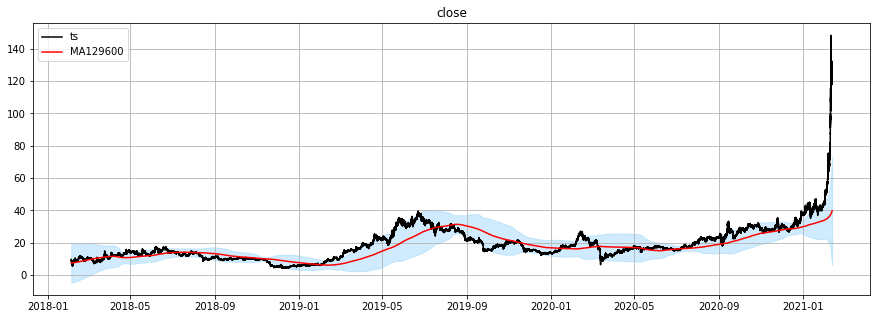

In [42]:
plot_ts(BNB['close'], plot_ma=True, plot_intervals=True, window=60*24*90, figsize=(15,5))

## Preprocessing

In [51]:
data_dict = _fill_data_dict()

### Config
Settings I define which can be varied. Further functions will be dynamically written with respect to these configs

In [52]:
features_aggregation_config = {
    'high': 'max',
    'low': 'min',
    'open': 'first',
    'close': 'last',
    'volume': 'sum',
    'number_of_trades': 'sum',
    'quote_asset_volume': 'sum',
    'taker_buy_base_asset_volume': 'sum',
    'taker_buy_quote_asset_volume': 'sum'
}

features = ['volume'
            , 'high'
            , 'low'
            , 'number_of_trades'
#              , 'RSI_24'
            , 'RSI_72'
#             , 'BBL_100_20'
#             ,  'BBM_100_20'
#             ,  'BBU_100_20'
#             ,  'BBB_100_20'
#              , 'BBL_50_20'
#             ,  'BBM_100_20'
#             ,  'BBU_50_20'
#             ,  'BBB_100_20'
             , 'FWMA_72'
#             , 'MACD_12_26_9'
#             , 'MACDh_12_26_9'
#             , 'MACDs_12_26_9'
           ]

frequency = '1H'
prediction_length = 8
param_grid =dict(
            n_forecasts=[8],
            n_lags=[8],
            num_hidden_layers=[0,1],
            batch_size=[76],
            epochs=[150],
            learning_rate=[.20],
            #loss_func=['MSE'],
            ar_sparsity=[.1, .3,.5, .8],
           # n_changepoints=[50],
            #trend_reg=1.00,
            )

### Resampling

Next up is resampling to change the frequency of the raw data to however I want to bend my trading.

In [53]:
def _downsample_binance_data_dict(data_dict, features_config, dt_col='open_time', freq='1H'):
    for ticker, ticker_data in data_dict.items():
        data_dict[ticker] = ticker_data.resample(freq).agg(features_config).reset_index()
    return data_dict

In [54]:
data_dict = _downsample_binance_data_dict(data_dict, features_config=features_aggregation_config, freq=frequency)

In [55]:
def _filter_by_date(data_dict, date_start=None, date_range=None):
    for ticker, ticker_data in data_dict.items():
        if date_start:
            data_dict[ticker] = ticker_data.query("open_time > @date_start")
        if date_range:
            data_dict[ticker] = ticker_data.query("open_time in @date_range")
        if date_start == date_range == None:
            raise ValueError("Either date_start or date_range must be specified!")
    return data_dict

In [56]:
data_dict = _filter_by_date(data_dict, date_start='2019-01-01')

### Feature extraction

Use library to extract technical indicators from historical data

In [57]:
import pandas as pd
import pandas_ta as ta

In [58]:
def _extract_ta_ind(data_dict):
    for ticker, ticker_data in data_dict.items():
        df = data_dict[ticker]
        df.ta.bbands(close=df['close'], length=100, append=True)
        df.ta.bbands(close=df['close'], length=50, append=True)
        df.ta.rsi(close=df['close'], length=24, append=True)
        df.ta.rsi(close=df['close'], length=72, append=True)
        df.ta.fwma(close=df['close'], length=72, append=True)
        df.ta.macd(close=df['close'], length=24, append=True)
        df.dropna(inplace=True)
        df.columns=df.columns.str.replace('.','')
        data_dict[ticker] = df
    return data_dict

In [59]:
data_dict = _extract_ta_ind(data_dict)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-58-82b78b7e0231>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns=df.columns.str.replace('.','')

  df.columns=df.columns.str.replace('.','')

WARNING - (py.warnings._showwarnmsg) - <ipython-input-58-82b78b7e0231>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns=df.columns.str.replace('.','')

  df.columns=df.columns.str.replace('.','')

WARNING - (py.warnings._showwarnmsg) - <ipython-input-58-82b78b7e0231>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when r

## Baseline model

In [60]:
def _persistence_baseline(data_dict, target='close', holdout=.1, prediction_length=4, metric='mae'):
    for ticker, df in data_dict.items():
        df = data_dict[ticker]
        test_idx = round(df.shape[0] - holdout * df.shape[0])
        test_df = df.iloc[test_idx:, :]
        test_df[f'Y_plus_{prediction_length}'] = test_df[target].shift(-prediction_length)
        test_df.dropna(inplace=True)
        mae = np.mean(np.absolute(test_df[f'Y_plus_{prediction_length}'].to_numpy() - test_df[target].to_numpy()))
        print(f"Mean absolute error of persistence model for {ticker}: {mae}")

In [61]:
test = _persistence_baseline(data_dict, prediction_length=8)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-60-7d7ae75bc951>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'Y_plus_{prediction_length}'] = test_df[target].shift(-prediction_length)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'Y_plus_{prediction_length}'] = test_df[target].shift(-prediction_length)

WARNING - (py.warnings._showwarnmsg) - c:\users\jong653\appdata\local\programs\python\python39\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a 

Mean absolute error of persistence model for BNB: 1.2172529697418213
Mean absolute error of persistence model for BTC: 704.9923706054688
Mean absolute error of persistence model for ETH: 27.921375274658203


## NeuralProphet

Install modified version of Neural prophet

In [16]:
import torch
torch.cuda.is_available()

True

In [74]:
!pip install git+https://github.com/Jeffrey-shipping-it/neural_prophet.git@feature/gpu_support --no-cache -U

Looking in indexes: https://artifacts.kpn.org/api/pypi/pypi/simple
  Cloning https://github.com/Jeffrey-shipping-it/neural_prophet.git (to revision feature/gpu_support) to c:\users\jong653\appdata\local\temp\pip-req-build-f4g15chd
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for neuralprophet: filename=neuralprophet-0.2.8-py3-none-any.whl size=59156 sha256=6fc47cfb35750ce1d39bf503307ed2823aaf8b94c4197f7537f46ff13ffaf8dd
  Stored in directory: C:\Users\jong653\AppData\Local\Temp\pip-ephem-wheel-cache-5me92pzz\wheels\9e\b8\13\b1298a245ba365d5c6f8d7426c7dce6aea7859481a07ac5efc
Successfully built neuralprophet
  Attempting uninstall: neuralprophet
    Found existing installation: neuralprophet 0.2.8
    Uninstal

You should consider upgrading via the 'c:\users\jong653\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


### Training

In [62]:
from neuralprophet import NeuralProphet
import logging
import itertools

In [63]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("test")

In [64]:
def add_missing_dates_nan(df, freq):
    """Fills missing datetimes in 'ds', with NaN for all other columns
    Args:
        df (pd.Dataframe): with column 'ds'  datetimes
        freq (str):Data step sizes. Frequency of data recording,
            Any valid frequency for pd.date_range, such as 'D' or 'M'
    Returns:
        dataframe without date-gaps but nan-values
    """
    if df["ds"].dtype == np.int64:
        df.loc[:, "ds"] = df.loc[:, "ds"].astype(str)
    df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

    data_len = len(df)
    r = pd.date_range(start=df["ds"].min(), end=df["ds"].max(), freq=freq)
    df_all = df.set_index("ds").reindex(r).rename_axis("ds").reset_index()
    num_added = len(df_all) - data_len
    return df_all, num_added

In [66]:
def preprocess_prophet(data_dict):
    for ticker, df in data_dict.items():
        df = df.reset_index().rename(columns={'close': 'y', 'open_time': 'ds'})
        df_new, num = add_missing_dates_nan(df, frequency)
        df_new.interpolate(method='ffill', inplace=True)
        df_new = df_new[['ds', 'y'] + features]
        data_dict[ticker] = df_new
    return data_dict

In [67]:
data_dict = preprocess_prophet(data_dict)

In [68]:
def tune_neuralprophet(df, param_grid):
    eval_frame = pd.DataFrame()
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    model_list = [] # Store the obtained val metrics here alongside models 
    logging.info(f"Fitting {len(all_params)} models")
    for params in all_params:
                logging.info(f"fitting model with the following parameters: {params}")
                m = NeuralProphet(**params,
                                    yearly_seasonality=False,
                                    weekly_seasonality=False,
                                    daily_seasonality=False,
                                    changepoints_range=1,
                                    impute_missing=True,
                                    gpu=False)  # create model object
                for feature in features:
                    m = m.add_lagged_regressor(feature)
                m.highlight_nth_step_ahead_of_each_forecast(step_number=m.n_forecasts)
                df = df[features + ['y', 'ds']]
                metrics = m.fit(df
                , freq=frequency
                , validate_each_epoch=True
                , valid_p=0.1
                , plot_live_loss=False
                   )
                new_row = pd.concat([pd.DataFrame(params, index=[0]), metrics.tail(1).set_index(pd.DataFrame(params, index=[0]).index)], axis=1)
                eval_frame = pd.concat([eval_frame, new_row])
    return eval_frame, list(metrics.columns)

def _fetch_best_params(eval_frame, metrics_columns):
    eval_frame.sort_values(f'MAE-{prediction_length}_val', ascending=False, inplace=True)
    best_row = eval_frame.head(1)
    best_params = best_row.drop(metrics_columns, axis=1).to_dict('records')[0]
    return best_params

In [69]:
def fit_neuralprophet(data_dict, param_grid):
    
    model_dict = {}
    for ticker, df in data_dict.items():
        model_dict[ticker] = {}
        logging.info(f"Fitting neuralprophet model for {ticker}")
        
        gridsearch_df, metric_cols = tune_neuralprophet(df, param_grid)
        
        best_params = _fetch_best_params(gridsearch_df, metric_cols)
        
        m = NeuralProphet(
        **best_params,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoints_range=1,
        impute_missing=True,
        gpu=False,
        )
        
        for feature in features:
            m = m.add_lagged_regressor(feature)
        df = df[features + ['y', 'ds']]
            
        m.highlight_nth_step_ahead_of_each_forecast(step_number=m.n_forecasts)
            
        metrics = m.fit(df
                , freq=frequency
                , validate_each_epoch=False
                , plot_live_loss=False
               )
        model_dict[ticker]['model'] = m
        model_dict[ticker]['metrics'] = gridsearch_df
        logging.info(f"Finished {ticker}")
    logging.info(f"Training of {len(model_dict.items())} models complete!")
    return model_dict

In [70]:
model_dict = fit_neuralprophet(data_dict, param_grid)

Epoch[150/150]: 100%|█| 150/150 [02:09<00:00,  1.16it/s, SmoothL1Loss=0.000111, MAE=0.245, MSE=0.163, MAPE=0.0282, SmoothL1Loss-8=0.000191, MAE-8=0.336, MSE-8=0.28, MAPE-8=0.0621, RegLoss=1.95e-5, MAE-8_val=1
Epoch[150/150]: 100%|█| 150/150 [02:10<00:00,  1.15it/s, SmoothL1Loss=0.000111, MAE=0.245, MSE=0.163, MAPE=0.0225, SmoothL1Loss-8=0.000191, MAE-8=0.337, MSE-8=0.28, MAPE-8=0.0544, RegLoss=4.16e-6, MAE-8_val=1
Epoch[150/150]: 100%|█| 150/150 [02:08<00:00,  1.16it/s, SmoothL1Loss=0.000111, MAE=0.245, MSE=0.163, MAPE=0.0286, SmoothL1Loss-8=0.000191, MAE-8=0.336, MSE-8=0.281, MAPE-8=0.0539, RegLoss=1.27e-6, MAE-8_val=
Epoch[150/150]: 100%|█| 150/150 [02:10<00:00,  1.15it/s, SmoothL1Loss=0.000111, MAE=0.245, MSE=0.163, MAPE=0.0632, SmoothL1Loss-8=0.000191, MAE-8=0.337, MSE-8=0.28, MAPE-8=0.0931, RegLoss=3.06e-7, MAE-8_val=1
Epoch[150/150]: 100%|█| 150/150 [02:44<00:00,  1.10s/it, SmoothL1Loss=0.00421, MAE=1.87, MSE=6.18, MAPE=1.74, SmoothL1Loss-8=0.00421, MAE-8=1.87, MSE-8=6.18, MAPE-8

In [104]:
import datetime
def _generate_validation_report(model_dict, save=True, folder=""):
    val_df = pd.DataFrame()
    for ticker, ticker_dict in model_dict.items():
        new_lines = ticker_dict['metrics'].copy()
        new_lines['ticker'] = ticker
        #new_lines.insert('ticker', ticker)
        val_df = val_df.append(new_lines)
    if save:
        val_df.to_csv(fr"validation_report_{datetime.date.today()}.csv")
        #val_df.to_csv(os.path.join(folder, f"validation_report_{pd.to_datetime('now')}.csv"), index=False)
    return val_df

In [105]:
validation_df = _generate_validation_report(model_dict, save=True)

In [106]:
validation_df

,n_forecasts,n_lags,num_hidden_layers,batch_size,epochs,learning_rate,ar_sparsity,SmoothL1Loss,MAE,MSE,...,RegLoss,SmoothL1Loss_val,MAE_val,MSE_val,MAPE_val,SmoothL1Loss-8_val,MAE-8_val,MSE-8_val,MAPE-8_val,ticker
0,8,8,1,76,150,0.2,0.8,0.004214,1.872169,6.182810,...,1.097894e-06,0.143916,9.430499,2.960464e+02,-15.250752,0.149477,9.604618,3.124326e+02,-15.399096,BNB
0,8,8,1,76,150,0.2,0.3,0.004215,1.871589,6.183662,...,1.005663e-05,0.143456,9.407229,2.951537e+02,-15.153885,0.149030,9.581684,3.115737e+02,-15.302884,BNB
0,8,8,1,76,150,0.2,0.1,0.004214,1.873250,6.182761,...,3.954304e-05,0.142812,9.373234,2.939439e+02,-15.019790,0.148374,9.547271,3.103245e+02,-15.168461,BNB
0,8,8,1,76,150,0.2,0.5,0.004214,1.873266,6.182669,...,4.386503e-06,0.142576,9.362859,2.935002e+02,-14.947704,0.148131,9.536613,3.098402e+02,-15.096354,BNB
0,8,8,0,76,150,0.2,0.3,0.000111,0.245401,0.163178,...,4.162256e-06,0.003081,0.805100,4.555575e+00,-0.443787,0.005185,1.124194,7.717032e+00,-0.751793,BNB
0,8,8,0,76,150,0.2,0.5,0.000111,0.245206,0.163190,...,1.270984e-06,0.003096,0.806752,4.576992e+00,-0.492170,0.005181,1.120451,7.709930e+00,-0.738415,BNB
0,8,8,0,76,150,0.2,0.8,0.000111,0.245180,0.163032,...,3.061964e-07,0.003090,0.806824,4.567705e+00,-0.468204,0.005157,1.120303,7.673693e+00,-0.748223,BNB
0,8,8,0,76,150,0.2,0.1,0.000111,0.245097,0.162927,...,1.953617e-05,0.003059,0.800687,4.521348e+00,-0.428292,0.005120,1.115448,7.616348e+00,-0.671786,BNB
0,8,8,1,76,150,0.2,0.1,0.004118,704.596834,754220.054414,...,4.054553e-05,0.431140,7307.136617,8.903975e+07,-20.769856,0.433870,7341.774932,8.969722e+07,-20.848246,BTC
0,8,8,1,76,150,0.2,0.8,0.004119,704.092544,754292.336493,...,1.106688e-06,0.430507,7300.548625,8.888093e+07,-20.750076,0.433270,7335.478295,8.954642e+07,-20.829211,BTC


In [57]:
import pickle

In [70]:
def _save_model_dict(model_dict, save_dir=os.listdir()):
    with open('models.pickle', 'wb') as handle:
        pickle.dump(model_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [71]:
_save_model_dict(model_dict)

In [58]:
def _load_model_dict(name='lol', load_dir=os.listdir()):
    with open('models.pickle', 'rb') as handle:
        model_dict = pickle.load(handle)
        return model_dict

In [59]:
lol_dict = _load_model_dict()

### Inference

In [43]:
model_dict['BNB']['model']

In [95]:
future = model.make_future_dataframe(data, periods=4, n_historic_predictions=False)

In [163]:
def predict_all(model_dict, data_dict):
    forecast_dict = {}
    for ticker, df in data_dict.items():
        data = df
        model = model_dict[ticker]['model']
        future = model.make_future_dataframe(data, periods=4, n_historic_predictions=False)
        forecast = model.predict(future)
        lookup_df = forecast.drop(['ds'],axis=1)
        projection = forecast.assign(y_pred=lookup_df.lookup(lookup_df.index, lookup_df.isnull().idxmin(1)))[['ds', 'y_pred']]
        forecast_dict[ticker] = projection
    return forecast_dict

In [164]:
forecast_dict = predict_all(model_dict, data_dict)

In [165]:
forecast_dict

{'BNB':                     ds      y_pred
 0  2021-02-11 10:00:00  123.519997
 1  2021-02-11 11:00:00  118.525703
 2  2021-02-11 12:00:00  121.985397
 3  2021-02-11 13:00:00  127.107002
 4  2021-02-11 14:00:00  127.250099
 5  2021-02-11 15:00:00  126.925201
 6  2021-02-11 16:00:00  123.676399
 7  2021-02-11 17:00:00  123.197800
 8  2021-02-11 18:00:00  123.749901
 9  2021-02-11 19:00:00  121.893997
 10 2021-02-11 20:00:00  121.397598
 11 2021-02-11 21:00:00  121.762703
 12 2021-02-11 22:00:00  123.763802
 13 2021-02-11 23:00:00  123.754402
 14 2021-02-12 00:00:00  120.693390
 15 2021-02-12 01:00:00  120.680069
 16 2021-02-12 02:00:00  120.679192
 17 2021-02-12 03:00:00  120.673843,
 'BTC':                     ds        y_pred
 0  2021-02-11 10:00:00  46279.800781
 1  2021-02-11 11:00:00  46061.488281
 2  2021-02-11 12:00:00  46516.390625
 3  2021-02-11 13:00:00  47555.460938
 4  2021-02-11 14:00:00  47864.808594
 5  2021-02-11 15:00:00  47960.851562
 6  2021-02-11 16:00:00  47590.5312

In [148]:
forecast = model.predict(future)

In [155]:
lookup_df = forecast.drop(['ds'],axis=1)

In [161]:
forecast.assign(y_pred=lookup_df.lookup(lookup_df.index, lookup_df.isnull().idxmin(1)))[['ds', 'y_pred']]

,ds,y_pred
0,2021-02-11 10:00:00,123.519997
1,2021-02-11 11:00:00,118.525703
2,2021-02-11 12:00:00,121.985397
3,2021-02-11 13:00:00,127.107002
4,2021-02-11 14:00:00,127.250099
5,2021-02-11 15:00:00,126.925201
6,2021-02-11 16:00:00,123.676399
7,2021-02-11 17:00:00,123.197800
8,2021-02-11 18:00:00,123.749901
9,2021-02-11 19:00:00,121.893997


In [137]:
forecast

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,lagged_regressor_high4,lagged_regressor_low1,lagged_regressor_low2,lagged_regressor_low3,lagged_regressor_low4,lagged_regressor_number_of_trades1,lagged_regressor_number_of_trades2,lagged_regressor_number_of_trades3,lagged_regressor_number_of_trades4,trend
0,2021-02-11 10:00:00,123.519997,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
1,2021-02-11 11:00:00,118.525703,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
2,2021-02-11 12:00:00,121.985397,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
3,2021-02-11 13:00:00,127.107002,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
4,2021-02-11 14:00:00,127.250099,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
5,2021-02-11 15:00:00,126.925201,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
6,2021-02-11 16:00:00,123.676399,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
7,2021-02-11 17:00:00,123.197800,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
8,2021-02-11 18:00:00,123.749901,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
9,2021-02-11 19:00:00,121.893997,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None


In [133]:
forecast = forecast.ffill(axis=0)

In [135]:
forecast.tail(4)

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,lagged_regressor_high4,lagged_regressor_low1,lagged_regressor_low2,lagged_regressor_low3,lagged_regressor_low4,lagged_regressor_number_of_trades1,lagged_regressor_number_of_trades2,lagged_regressor_number_of_trades3,lagged_regressor_number_of_trades4,trend
14,2021-02-12 00:00:00,123.754402,120.69339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.784118
15,2021-02-12 01:00:00,123.754402,120.69339,NaN,120.680069,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.784044
16,2021-02-12 02:00:00,123.754402,120.69339,NaN,120.680069,NaN,120.679192,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.783970
17,2021-02-12 03:00:00,123.754402,120.69339,NaN,120.680069,NaN,120.679192,NaN,120.673843,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.783895


In [128]:
forecast

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,lagged_regressor_high4,lagged_regressor_low1,lagged_regressor_low2,lagged_regressor_low3,lagged_regressor_low4,lagged_regressor_number_of_trades1,lagged_regressor_number_of_trades2,lagged_regressor_number_of_trades3,lagged_regressor_number_of_trades4,trend
0,2021-02-11 10:00:00,123.519997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-11 11:00:00,118.525703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-11 12:00:00,121.985397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-02-11 13:00:00,127.107002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-02-11 14:00:00,127.250099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-02-11 15:00:00,126.925201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2021-02-11 16:00:00,123.676399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2021-02-11 17:00:00,123.197800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2021-02-11 18:00:00,123.749901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2021-02-11 19:00:00,121.893997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


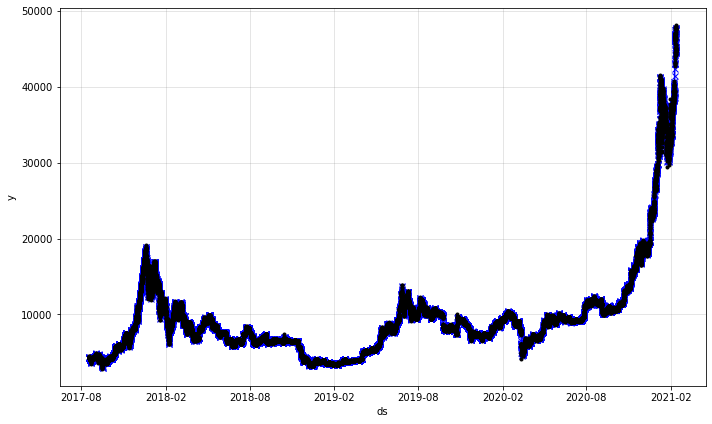

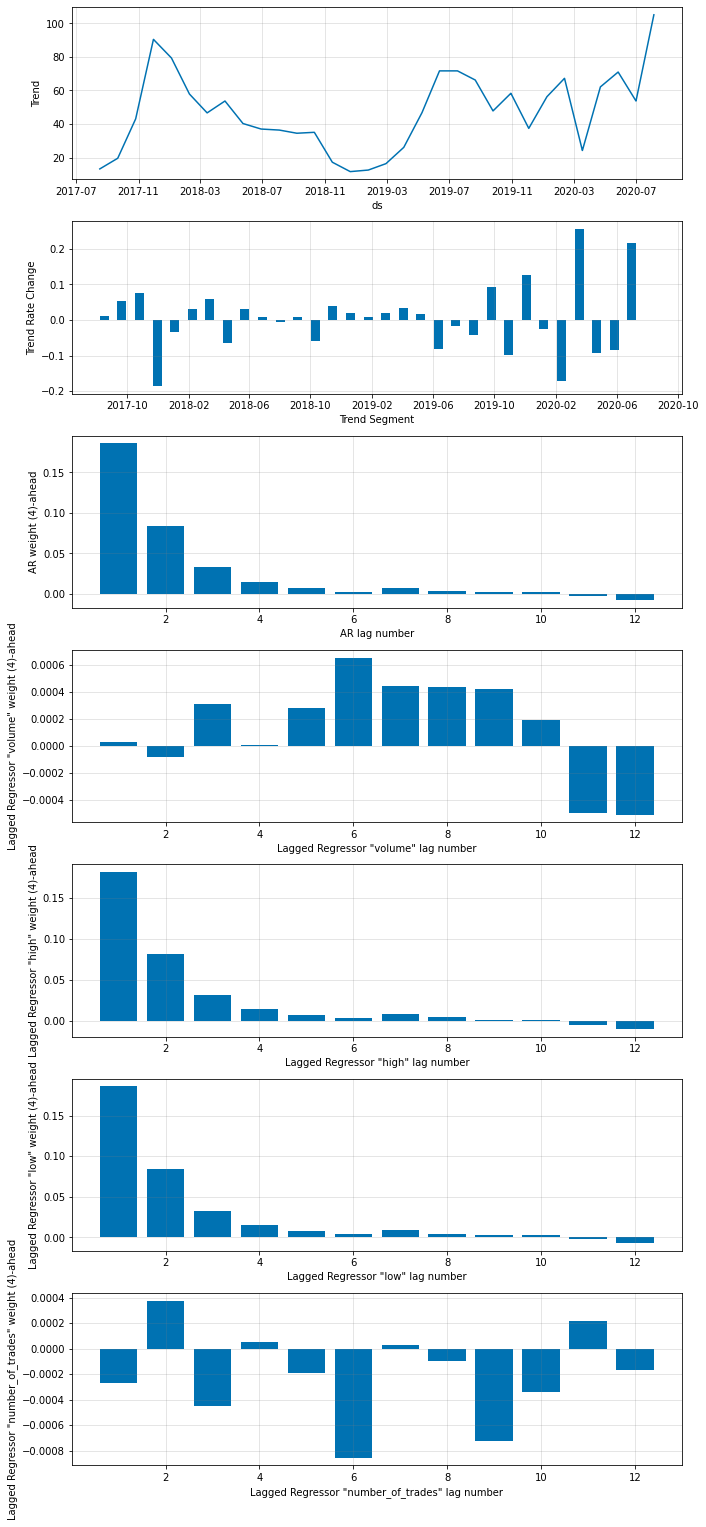

In [42]:
fig1 = m.plot(forecast)
fig2 = m.plot_parameters()

In [436]:
forecast

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,lagged_regressor_number_of_trades8,lagged_regressor_number_of_trades9,lagged_regressor_number_of_trades10,lagged_regressor_number_of_trades11,lagged_regressor_number_of_trades12,lagged_regressor_number_of_trades13,lagged_regressor_number_of_trades14,lagged_regressor_number_of_trades15,lagged_regressor_number_of_trades16,trend
0,2017-08-17 04:00:00,4308.830078,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2017-08-17 04:15:00,4310.452637,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2017-08-17 04:30:00,4312.075195,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2017-08-17 04:45:00,4313.697266,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2017-08-17 05:00:00,4315.319824,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122392,2021-02-12 02:00:00,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,-106.622,-82.3855,-92.4026,-75.489,-60.6771,2299.79
122393,2021-02-12 02:15:00,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,-71.3567,-78.2282,-65.0435,-63.0345,2299.8
122394,2021-02-12 02:30:00,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,-67.2527,-67.2296,-59.957,2299.81
122395,2021-02-12 02:45:00,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,-53.3054,-76.1095,2299.83
